In [1]:
!pip install wordcloud
!pip install tweet-preprocessor

In [2]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import re
import tensorflow as tf
%matplotlib inline
import nltk
from nltk.corpus import stopwords
from nltk import PorterStemmer
nltk.download('stopwords')
nltk.download('punkt')
from wordcloud import WordCloud

import preprocessor as p

from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings("ignore")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Download and Load data from Kaggle directly

In [3]:
# Install Kaggle API
!pip install --quiet kaggle

In [4]:
!pip install --upgrade --force-reinstall --no-deps kaggle

Processing /root/.cache/pip/wheels/a1/6a/26/d30b7499ff85a4a4593377a87ecf55f7d08af42f0de9b60303/kaggle-1.5.12-cp37-none-any.whl
  Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [5]:
 # Choose kaggle.json that created for new API token in your account
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (3).json


{'kaggle.json': b'{"username":"orchidchetiaphukan","key":"099afcb8eb32dde9885cd0bdf0e3389b"}'}

In [6]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Check the file in its new directory
!ls /root/.kaggle/
# Check the file permission
!ls -l ~/.kaggle/kaggle.json
#Change the file permission
# chmod 600 file – owner can read and write
# chmod 700 file – owner can read, write and execute
!chmod 600 ~/.kaggle/kaggle.json

input  kaggle.json
-rw------- 1 root root 74 Jun 24 08:41 /root/.kaggle/kaggle.json


In [7]:
! kaggle datasets download -d 'kazanova/sentiment140'
!unzip -q sentiment140.zip  -d .

sentiment140.zip: Skipping, found more recently modified local copy (use --force to force download)
replace ./training.1600000.processed.noemoticon.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [8]:
! ls /content

 drive		    sample_data
'kaggle (1).json'   sentiment140.zip
'kaggle (2).json'   tokenizer.pickle
'kaggle (3).json'   training.1600000.processed.noemoticon.csv
 kaggle.json


In [9]:
!mkdir /root/.kaggle/input

mkdir: cannot create directory ‘/root/.kaggle/input’: File exists


In [10]:
!cp training.1600000.processed.noemoticon.csv  ~/.kaggle/input

In [11]:
!ls /root/.kaggle/input

training.1600000.processed.noemoticon.csv


# Classification of Depressive and Normal Tweets

## Datasets

###For this analysis Sentiment140 Dataset is used 
https://www.kaggle.com/kazanova/sentiment140


In [12]:
encoding = 'ISO-8859-1'
col_names = ['target', 'id', 'date', 'flag', 'user', 'text']

dataset = pd.read_csv('/root/.kaggle/input/training.1600000.processed.noemoticon.csv', encoding=encoding, names=col_names)

In [13]:
dataset.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [14]:
df = dataset.copy().sample(8000, random_state=42)
df["label"] = 0
df = df[['text', 'label']]
df.dropna(inplace=True)
df.head()

,text,label
541200,@chrishasboobs AHHH I HOPE YOUR OK!!!,0
750,"@misstoriblack cool , i have no tweet apps fo...",0
766711,@TiannaChaos i know just family drama. its la...,0
285055,School email won't open and I have geography ...,0
705995,upper airways problem,0


In [15]:
df.shape

(8000, 2)

### Dataset scraped by twint
https://github.com/peijoy/DetectDepressionInTwitterPosts

In [16]:
col_names = ['id', 'text']
df2 = pd.read_csv('/content/drive/MyDrive/AIHack/depressive_tweets_processed.csv', 
                  sep = '|', header = None, usecols = [0,5], nrows = 3200, names=col_names) 
df2.head()

,id,text
0,989292962323615744,The lack of this understanding is a small but ...
1,989292959844663296,i just told my parents about my depression and...
2,989292951716155392,depression is something i don't speak about ev...
3,989292873664393218,Made myself a tortilla filled with pb&j. My de...
4,989292856119472128,@WorldofOutlaws I am gonna need depression med...


In [17]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2345 entries, 0 to 2344
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2345 non-null   object
 1   text    2313 non-null   object
dtypes: object(2)
memory usage: 36.8+ KB


In [18]:
df2.shape

(2345, 2)

In [19]:
# add `label` colum with value 1's
df2['label'] = 1
df2 = df2[['text', 'label']]

In [20]:
df = pd.concat([df,df2]) # merge the dataset on normal tweets and depressive tweets
df = df.sample(frac=1)  # shuffle the dataset

0 : Not Depressed

1 : Depressed

In [21]:
df['label'].value_counts()

0    8000
1    2345
Name: label, dtype: int64

## Text Preprocessing

In [22]:
# Expand Contraction
clist =  pd.read_json('/content/drive/MyDrive/AIHack/eng_contractions.txt', typ='series')
clist = clist.to_dict()

In [23]:
c_re = re.compile('(%s)' % '|'.join(clist.keys()))

def expandContractions(text, c_re=c_re):
    def replace(match):
        return cList[match.group(0)]
    return c_re.sub(replace, text)


In [24]:
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')

def clean_tweets(tweets):
    cleaned_tweets = []
    for tweet in tweets:
        tweet = str(tweet)
        tweet = tweet.lower()
        tweet = BAD_SYMBOLS_RE.sub(' ', tweet)
        tweet = p.clean(tweet)
        
        #expand contraction
        tweet = expandContractions(tweet)

        #remove punctuation
        tweet = ' '.join(re.sub("([^0-9A-Za-z \t])", " ", tweet).split())

        #stop words
        stop_words = set(stopwords.words('english'))
        word_tokens = nltk.word_tokenize(tweet) 
        filtered_sentence = [w for w in word_tokens if not w in stop_words]
        tweet = ' '.join(filtered_sentence)
        
        cleaned_tweets.append(tweet)
        
    return cleaned_tweets

In [25]:
X = clean_tweets([tweet for tweet in df['text']])
X = [str(i) for i in X]
print(X[0:5])

['everything music singing http plurk com p wxonj', 'sooooo tired loads morning ugh night', 'laurakbuzz sadly deep thought think farely difficult describe paralyzing depression struggle stand rights', 'anastaciakayray fixed go back', 'depression coming like dark horse']


## Word Analysis

In [26]:
depressive_tweets = [clean_tweets([t for t in df2['text']])]
depressive_words = ' '.join(list(map(str, depressive_tweets)))
depressive_wc = WordCloud(width = 512,height = 512, collocations=False,background_color='white', colormap="GnBu_r").generate(depressive_words)

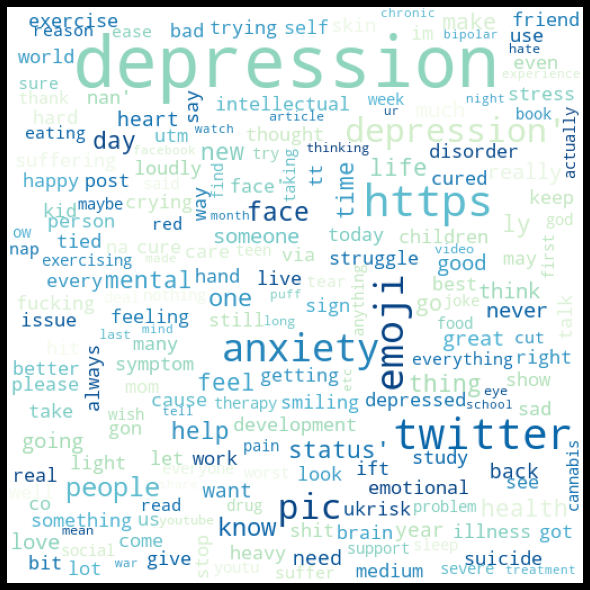

In [27]:
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(depressive_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

## Baseline Model

In [28]:
# X is the Feature after TEXT CLEANING IS DONE
y = df['label']

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X,y , test_size = 0.1, random_state = 42)


In [30]:
# Train data Tokenization
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 10000
# Max number of words in each Text.
MAX_SEQ_LENGTH = 140
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=MAX_NB_WORDS,oov_token='OOV', filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~')
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
word_vector = tokenizer.texts_to_sequences(X_train)
input_tensor = pd.DataFrame(tf.keras.preprocessing.sequence.pad_sequences(word_vector, maxlen=MAX_SEQ_LENGTH))
input_tensor.head()
print('Found %s unique tokens.' % len(word_index))

Found 19220 unique tokens.


In [31]:
# Saving the tokenizer as pickle file
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [32]:
# Test data Tokenization
X_test = tokenizer.texts_to_sequences(X_test)
X_test = pd.DataFrame(tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=MAX_SEQ_LENGTH))
X_test.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,318,58,277,215,232,156,86,215,869,232,50,1
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1572,1,1,1,749,43,17,2605,724,4001,479,1,7,459,50,151,789,2,826,1374
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,68,15,626,532,486,2,724,180,17,10,801,180,1
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,287,1,442,186,57,87,9
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1431,2,1,560,2464,439,84,1,10,5,3,1,82


In [33]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.97):
      print("\nReached 97% accuracy so cancelling training!")
      self.model.stop_training = True
callback = myCallback()

checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath = '/content/drive/MyDrive/AIHack/model/maindrop.hdf5',
                                                  monitor = 'val_accuracy', 
                                                  verbose = 1, 
                                                  save_best_only = True,
                                                  save_weights_only = True,
                                                  mode = 'max')
callbacks = [callback, checkpointer]

In [34]:
print(input_tensor.shape[1])

140


In [35]:
EMBEDDING_DIM = 300
def create_model():
   model = tf.keras.Sequential([
                              tf.keras.layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM,input_length = input_tensor.shape[1]),
                              tf.keras.layers.LSTM(300),
                              tf.keras.layers.Dense(100, activation="relu"),
                              tf.keras.layers.Dropout(0.25),
                              tf.keras.layers.Dropout(0.2),
                              tf.keras.layers.Dense(1, activation='sigmoid')])

   return model

model = create_model()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 

In [36]:
history = model.fit(input_tensor, y_train, batch_size=16, epochs=1 , callbacks = callbacks,validation_split = 0.1)

524/524 [==============================] - 339s 644ms/step - loss: 0.0821 - accuracy: 0.9748 - val_loss: 0.0382 - val_accuracy: 0.9925

Reached 97% accuracy so cancelling training!

Epoch 00001: val_accuracy improved from -inf to 0.99248, saving model to /content/drive/MyDrive/AIHack/model/maindrop.hdf5


In [37]:
def load_model(weights_path):
  model = create_model()
  model.load_weights(weights_path)
  return model

In [38]:
new_model1 =  load_model('/content/drive/MyDrive/AIHack/model/maindrop.hdf5')
new_model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 140, 300)          3000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 300)               721200    
_________________________________________________________________
dense_2 (Dense)              (None, 100)               30100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 3,751,401
Trainable params: 3,751,401
Non-trainable params: 0
____________________________________________

In [39]:
y_pred = (new_model1.predict(X_test) > 0.5).astype("int32")
print(y_pred)
print(type(y_pred))

[[0]
 [1]
 [1]
 ...
 [0]
 [0]
 [0]]
<class 'numpy.ndarray'>


In [40]:
from sklearn.metrics import classification_report
clreport = classification_report(y_test, y_pred)
print(clreport)

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       801
           1       1.00      0.97      0.98       234

    accuracy                           0.99      1035
   macro avg       0.99      0.99      0.99      1035
weighted avg       0.99      0.99      0.99      1035



In [41]:
y_predtr = (new_model1.predict(input_tensor) > 0.5).astype("int32")
print("Train Accuracy")
from sklearn.metrics import accuracy_score
print(accuracy_score(y_train, y_predtr))

Train Accuracy
0.9954887218045113


In [42]:
y_pred = (new_model1.predict(X_test) > 0.5).astype("int32")
print("Test Accuracy")
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test , y_pred)
print(acc)

Test Accuracy
0.9932367149758454
